### ข้อมูลการขายของ Walmart จากช่วงวันที่ 29-01-2011 ถึง 24-04-2016 รวมทั้งหมด 1913 วัน 
### โจทย์คือ ให้คาดการณ์ยอดขายสินค้าที่ร้านค้าในสาขาต่างๆ เป็นเวลา 28 วัน
### จุดประสงค์คือ จัดเตรียมสินค้าให้เหมาะสมเพื่อเพิ่มยอดขายและลดต้นทุน เมื่อสินค้าของแต่ละสาขามีความต้องการมากน้อยต่างกันในแต่ละวัน

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import *
import lightgbm
from sklearn.ensemble import RandomForestRegressor
import warnings
warnings.filterwarnings('ignore')

In [2]:
calendar = pd.read_csv('calendar.csv')
calendar.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


In [3]:
price = pd.read_csv('sell_prices.csv.zip')
price.head()

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26


In [4]:
sale = pd.read_csv('sales_train_validation.csv.zip')
sale.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4


### ตาราง calendar : ประกอบด้วยข้อมูลเกี่ยวกับวันที่ขายผลิตภัณฑ์
•	date: The date in a “y-m-d” format.\
•	wm_yr_wk: The id of the week the date belongs to.\
•	weekday: The type of the day (Saturday, Sunday, …, Friday).\
•	wday: The id of the weekday, starting from Saturday.\
•	month: The month of the date.\
•	year: The year of the date.\
•	event_name_1: If the date includes an event, the name of this event.\
•	event_type_1: If the date includes an event, the type of this event.\
•	event_name_2: If the date includes a second event, the name of this event.\
•	event_type_2: If the date includes a second event, the type of this event.\
•	snap_CA, snap_TX, and snap_WI: A binary variable (0 or 1) indicating whether the stores of CA, TX or WI allow SNAP  purchases on the examined date. 1 indicates that SNAP purchases are allowed.



### ตาราง price : ประกอบด้วยข้อมูลเกี่ยวกับราคาของผลิตภัณฑ์ที่ขายต่อร้านค้าและวันที่
•	store_id: The id of the store where the product is sold. \
•	item_id: The id of the product.\
•	wm_yr_wk: The id of the week.\
•	sell_price: The price of the product for the given week/store. The price is provided per week (average across seven days). If not available, this means that the product was not sold during the examined week. Note that although prices are constant at weekly basis, they may change through time (both training and test set).



### ตาราง sale : ข้อมูลการขายหน่วยรายวันในอดีตของผลิตภัณฑ์และร้านค้า
•	item_id: The id of the product.\
•	dept_id: The id of the department the product belongs to.\
•	cat_id: The id of the category the product belongs to.\
•	store_id: The id of the store where the product is sold.\
•	state_id: The State where the store is located.\
•	d_1, d_2, …, d_i, … d_1941: The number of units sold at day i, starting from 2011-01-29.

In [5]:
sale.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4


In [6]:
sale.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30490 entries, 0 to 30489
Columns: 1919 entries, id to d_1913
dtypes: int64(1913), object(6)
memory usage: 446.4+ MB


### ตาราง sale ใช้ memory 446 MB ซึ่งถือว่าเยอะมาก

### ต้องแปลงข้อมูลให้อยู่ในรูปแบบที่ถูกต้องและลด memory usage

In [7]:
def transform_data(df):
    col_index = df.dtypes.index
    col_type = df.dtypes.values
    for i , val in enumerate(col_type):
        
        if 'int' in str(val):
            if df[col_index[i]].min() > np.iinfo(np.int8).min and df[col_index[i]].max() < np.iinfo(np.int8).max :
                df[col_index[i]] = df[col_index[i]].astype(np.int8)
            elif df[col_index[i]].min() > np.iinfo(np.int16).min and df[col_index[i]].max() < np.iinfo(np.int16).max :
                df[col_index[i]] = df[col_index[i]].astype(np.int16)
            elif df[col_index[i]].min() > np.iinfo(np.int32).min and df[col_index[i]].max() < np.iinfo(np.int32).max :
                df[col_index[i]] = df[col_index[i]].astype(np.int32)
            else:
                df[col_index[i]] = df[col_index[i]].astype(np.int64)
                
        elif val == np.object :
            if col_index[i] == 'date' :
                df[col_index[i]] = pd.to_datetime(df[col_index[i]])
            else :
                df[col_index[i]] = df[col_index[i]].astype('category')
                
    return df
            


In [8]:
transform_data(price)
transform_data(calendar)
transform_data(sale)

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,FOODS_3_823_WI_3_validation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,0,0,2,2,...,2,0,0,0,0,0,1,0,0,1
30486,FOODS_3_824_WI_3_validation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
30487,FOODS_3_825_WI_3_validation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,0,6,0,2,...,2,1,0,2,0,1,0,0,1,0
30488,FOODS_3_826_WI_3_validation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,0,0,0,0,...,0,0,1,0,0,1,0,3,1,3


In [9]:
sale.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30490 entries, 0 to 30489
Columns: 1919 entries, id to d_1913
dtypes: category(6), int16(1306), int8(607)
memory usage: 95.2 MB


### จาก 446 MB เหลือ 95 MB เยี่ยม ใช้ได้ ใช้ได้

In [10]:
data = sale.melt(id_vars=['id','item_id','dept_id','cat_id','store_id','state_id'] , var_name='d' , value_name='sale')

In [11]:
data.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,sale
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0


### รวม 3 ตารางเข้าด้วยกัน

In [12]:
data = pd.merge(data , calendar , on='d' , how='left')

In [13]:
data = pd.merge(data , price , on=['store_id'	,'item_id'	,'wm_yr_wk'] , how='left')

In [14]:
data['sell_price'] = data['sell_price'].astype(np.float16)

In [15]:
data['sell_price'] = data['sell_price'].fillna(0)

### นำราคาต่อหน่วย คูณด้วย จำนวนสินค้าที่ขายได้

In [16]:
data['total'] = data['sale'] * data['sell_price']

In [17]:
data['d'] = data['d'].str.replace('d_' , '').astype(np.int16)

In [18]:
data.sample(5)

,id,item_id,dept_id,cat_id,store_id,state_id,d,sale,date,wm_yr_wk,...,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,total
34878124,HOUSEHOLD_1_051_WI_3_validation,HOUSEHOLD_1_051,HOUSEHOLD_1,HOUSEHOLD,WI_3,WI,1144,0,2014-03-17,11407,...,2014,StPatricksDay,Cultural,NaN,NaN,0,0,0,2.960938,0.000000
55232989,HOBBIES_1_363_TX_2_validation,HOBBIES_1_363,HOBBIES_1,HOBBIES,TX_2,TX,1812,0,2016-01-14,11550,...,2016,NaN,NaN,NaN,NaN,0,0,1,2.880859,0.000000
48501134,HOUSEHOLD_1_131_WI_1_validation,HOUSEHOLD_1_131,HOUSEHOLD_1,HOUSEHOLD,WI_1,WI,1591,1,2015-06-07,11519,...,2015,NaN,NaN,NaN,NaN,1,1,0,4.941406,4.941406
31371807,HOUSEHOLD_1_085_WI_3_validation,HOUSEHOLD_1_085,HOUSEHOLD_1,HOUSEHOLD,WI_3,WI,1029,0,2013-11-22,11343,...,2013,NaN,NaN,NaN,NaN,0,0,0,16.671875,0.000000
35818785,FOODS_2_356_WI_1_validation,FOODS_2_356,FOODS_2,FOODS,WI_1,WI,1175,0,2014-04-17,11411,...,2014,NaN,NaN,NaN,NaN,0,0,0,2.500000,0.000000


In [19]:
data['week'] = data['date'].dt.week.astype(np.int8)

In [20]:
data.sample(5)

,id,item_id,dept_id,cat_id,store_id,state_id,d,sale,date,wm_yr_wk,...,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,total,week
1138674,HOUSEHOLD_2_302_CA_4_validation,HOUSEHOLD_2_302,HOUSEHOLD_2,HOUSEHOLD,CA_4,CA,38,0,2011-03-07,11106,...,NaN,NaN,NaN,NaN,1,1,0,0.000000,0.000000,10
29342142,FOODS_1_004_CA_4_validation,FOODS_1_004,FOODS_1,FOODS,CA_4,CA,963,1,2013-09-17,11334,...,NaN,NaN,NaN,NaN,0,0,0,1.780273,1.780273,38
54475539,FOODS_2_279_TX_3_validation,FOODS_2_279,FOODS_2,FOODS,TX_3,TX,1787,0,2015-12-20,11547,...,NaN,NaN,NaN,NaN,0,0,0,2.470703,0.000000,51
34473020,HOUSEHOLD_1_471_TX_3_validation,HOUSEHOLD_1_471,HOUSEHOLD_1,HOUSEHOLD,TX_3,TX,1131,1,2014-03-04,11405,...,NaN,NaN,NaN,NaN,1,0,0,2.480469,2.480469,10
50512702,FOODS_3_747_TX_3_validation,FOODS_3_747,FOODS_3,FOODS,TX_3,TX,1657,2,2015-08-12,11528,...,NaN,NaN,NaN,NaN,0,1,1,1.000000,2.000000,33


In [21]:
plt.style.use('seaborn-darkgrid')

## ได้ข้อมูลมาแล้ว ข้อมูลบอกอะไรเราบ้าง ?

### ยอดขายสินค้ารายวันตั้งแต่ 29-01-2011 ถึง 24-04-2016

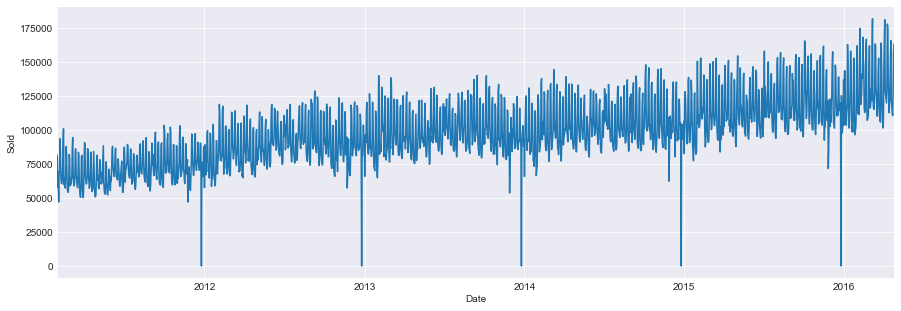

In [22]:
data.groupby('date')['total'].sum().plot(figsize=(15,5))
plt.xlabel('Date')
plt.ylabel('Sold');

### ยอดขายสินค้ารายวันตั้งแต่ 29-01-2011 ถึง 24-04-2016 (แบ่งตามชนิดสินค้า)

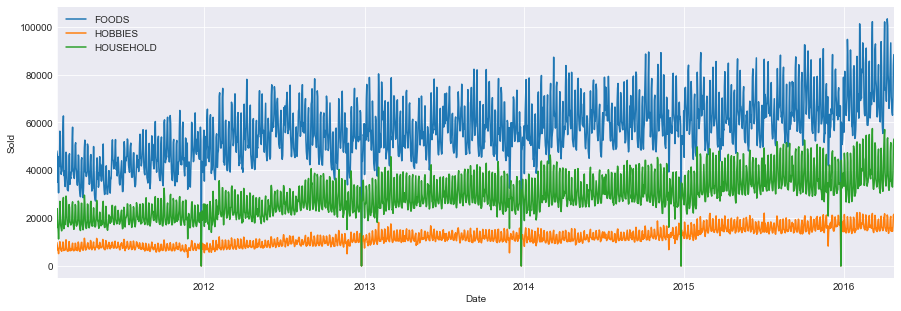

In [23]:
data.groupby(['date' , 'cat_id'])['total'].sum().unstack().plot(figsize=(15,5))
plt.xlabel('Date')
plt.ylabel('Sold')
plt.legend(title='');

### ส่วนแบ่งการตลาด ตามชนิดสินค้า

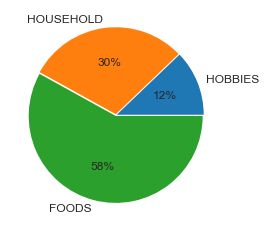

In [24]:
plt.pie(data.groupby('cat_id')['total'].sum().sort_values() , 
        labels=data.groupby('cat_id')['total'].sum().sort_values().index , 
        explode=(0.01,0.01,0.01) , autopct='%.0f%%' , textprops=dict(fontsize=12));

### ส่วนแบ่งการตลาด(รายปี) ตามชนิดสินค้า

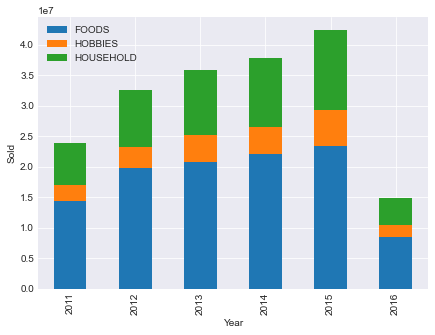

In [25]:
data.pivot_table(index='year' , columns='cat_id' , values='total' , aggfunc=sum).plot(kind='bar' , stacked=True,
                                                                                     figsize=(7,5))
plt.xlabel('Year')
plt.ylabel('Sold')
plt.legend(title='');

---------------------

### แล้วจำนวนร้านค้าของ Walmart ล่ะ ?

In [26]:
for i in data['state_id'].unique():
    print(i)

CA
TX
WI


### แล้วจำนวนสาขาแต่ละเมืองล่ะ ?

In [27]:
for i in data['store_id'].unique():
    print(i)

CA_1
CA_2
CA_3
CA_4
TX_1
TX_2
TX_3
WI_1
WI_2
WI_3


#### เห็นได้ว่า Walmart มีร้านค้าอยู่ 3 เมือง 
#### แต่ละเมืองมีสาขาคือ เมือง CA มีสาขา 1,2,3,4 ส่วนเมือง TX และ WI มีสาขา 1,2,3
#### โดยเราจะเจาะลึกลงไปที่สาขา 1 ของแต่ละเมือง (CA_1 , TX_1 , WI_1)

### ยอดขายแต่ละสาขา

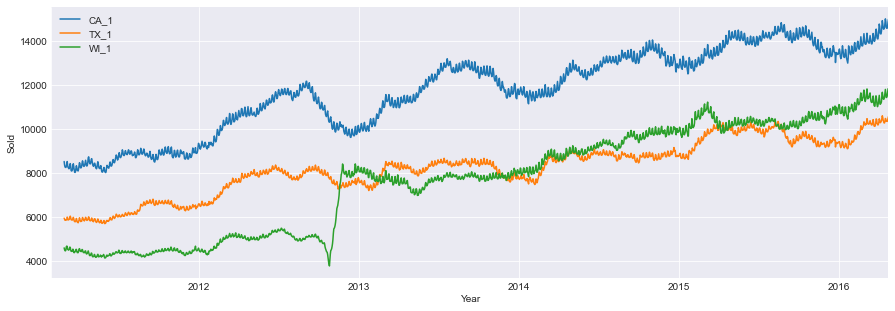

In [28]:
data[data['store_id'] == 'CA_1'].groupby('date')['total'].sum().rolling(30).mean().plot(figsize=(15,5))
data[data['store_id'] == 'TX_1'].groupby('date')['total'].sum().rolling(30).mean().plot(figsize=(15,5))
data[data['store_id'] == 'WI_1'].groupby('date')['total'].sum().rolling(30).mean().plot(figsize=(15,5))
plt.xlabel('Year')
plt.ylabel('Sold')
plt.legend(['CA_1' , 'TX_1' , 'WI_1']);

#### ดูเหมือนว่าปลายปี 2012 ของสาขา WI_1 มียอดขายพุ่งขึ้นอย่างเห็นได้ชัด
#### สวนทางกับสาขา CA_1 ในช่วงเวลาเดียวกัน ที่มียอดขายลดลง

### แล้วยอดขายสินค้าแต่ละชนิด ในแต่ละสาขาล่ะ ?

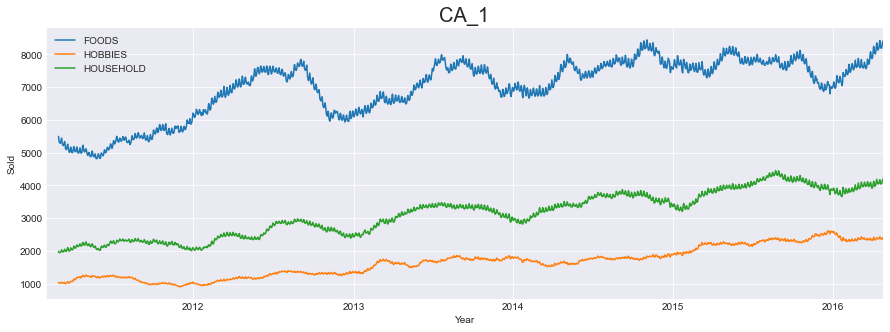

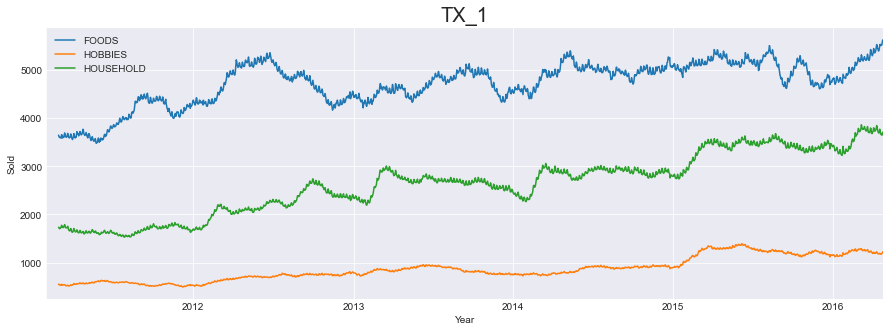

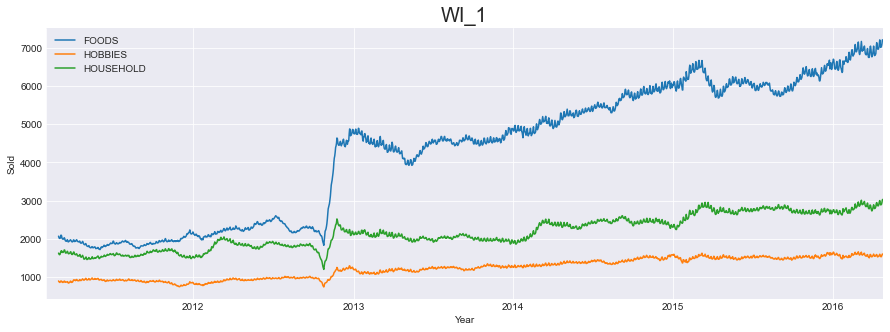

In [29]:
for i , val in enumerate(['CA_1' , 'TX_1' , 'WI_1']) :
    data[data['store_id'] == val].groupby(['date','cat_id'])['total'].sum().unstack().rolling(30).mean().plot(figsize=(15,5))
    plt.title(val , fontsize=20)
    plt.xlabel('Year')
    plt.ylabel('Sold')
    plt.legend(title='');

CA_1 : สินค้าชนิด FOODS และ HOUSEHOLD ปลายปีจะมียอดขายลดลงทุกปี\
TX_1 : เช่นเดียวกันกับสาขา CA_1 ที่สินค้าชนิด FOODS และ HOUSEHOLD ปลายปีจะมียอดขายลดลงทุกปี แต่ต้นปียอดขายจะพุ่งขึ้นเล็กน้อย\
WI_1 : สินค้าทุกชนิดตั้งแต่ต้นปี 2011 จนถึงปลายปี 2012 มียอดขายค่อนข้างคงที่ จนกระทั่งปลายปี 2012 สินค้าทุกชนิดยอดขายตกอยู่ระยะหนึ่งแล้วดีดตัวขึ้นไปเป็นอย่างมาก
    โดยเฉพาะ FOODS ที่ดีดจาก 2000 ขึ้นไปที่ 5000 และยอดขายมีอัตรขึ้นเรื่อยๆจนทิ้งห่างสินค้าอีก 2 ชนิด

### แล้วยอดขาย(รายวัน) ตลอดทั้งปีล่ะ ?

#### สีเข้มหมายถึงมียอดขายสินค้าที่สูง สีอ่อนหมายถึงมียอดขายสินค้าที่ต่ำ

In [30]:
def heatmap(store , color):
    fig , ax = plt.subplots(3,1 , figsize=(15,10))
    ax = ax.ravel()
    for i , val in enumerate(data['cat_id'].unique()):
        sns.heatmap(data[(data['store_id'] == store) & (data['cat_id'] == val)].pivot_table(index='weekday' , columns='week' , values='sale') , 
                    cbar=False,cmap=color ,ax=ax[i],)
        ax[i].set_title(f'{store} : {val}' , fontsize=20)
        ax[i].set_ylabel('')
        plt.tight_layout()

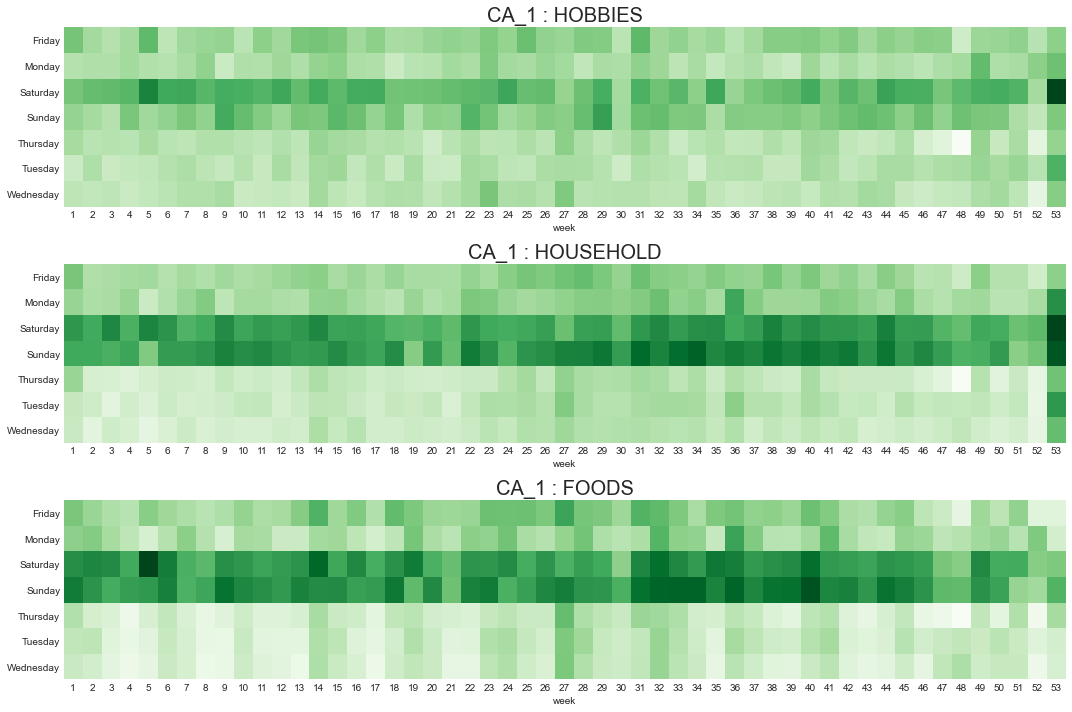

In [31]:
heatmap('CA_1' , 'Greens')

CA_1 HOBBIE : ยอดขายค่อนต่ำ และขายดีวันเสาร์และอาทิตย์ สัปดาห์สุดท้ายของปียอดขายจะพุ่งสูงขึ้น โดยเฉพาะวันเสาร์\
CA_1 HOUSEHOLD : ยอดขายสูงวันเสาร์และอาทิตย์ สัปดาห์สุดท้ายของปียอดขายจะพุ่งสูงขึ้นแทบทุกวัน\
CA_1 FOODS : ยอดขายสูงวันเสาร์และอาทิตย์ เดือนสุดท้ายของปียอดขายลดลง

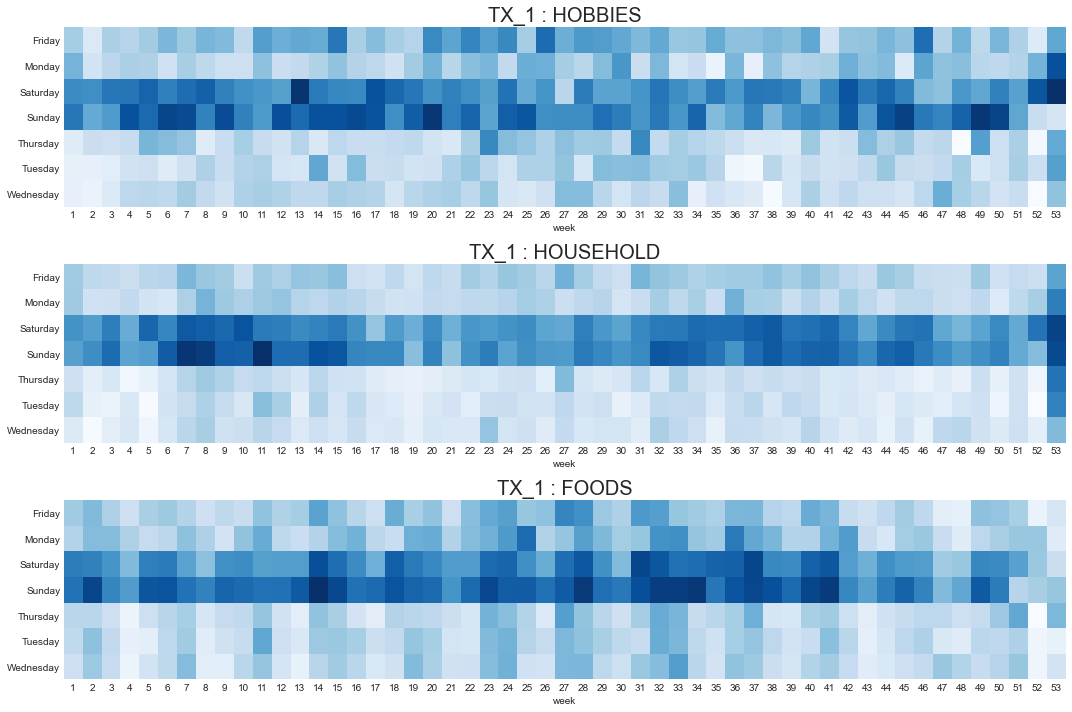

In [32]:
heatmap('TX_1' , 'Blues')

TX_1 HOBBIE : ขายดีเฉพาะวันเสาร์และอาทิตย์ สัปดาห์สุดท้ายของปียอดขายจะพุ่งสูงขึ้นทุกวัน โดยเฉพาะวันเสาร์\
TX_1 HOUSEHOLD : ขายดีเฉพาะวันเสาร์และอาทิตย์ โดยเฉพาะสัปดาห์ที่ 7-15 สัปดาห์สุดท้ายของปียอดขายจะพุ่งสูงขึ้นแทบทุกวัน โดยเฉพาะวันเสาร์-อาทิตย์\
TX_1 FOODS : ยอดขายสูงวันเสาร์และอาทิตย์ ยอดขายลดลงทุกๆสัปดาห์สุดท้ายของแต่ละเดือน

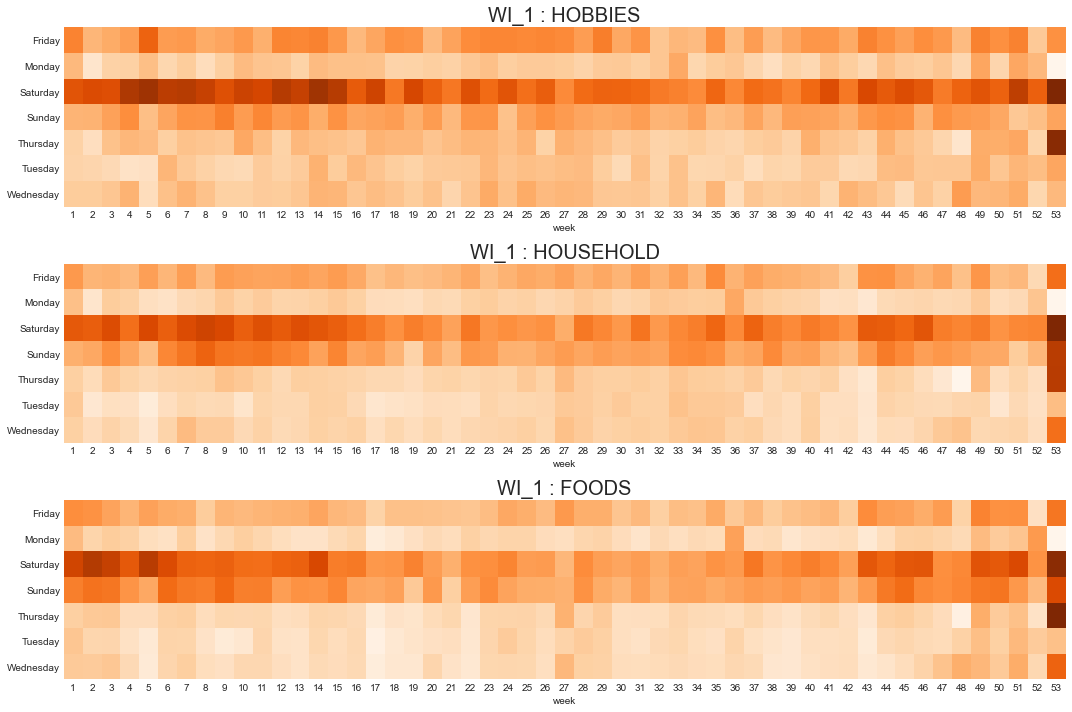

In [33]:
heatmap('WI_1' , 'Oranges')

WI_1 HOBBIE : ขายดีเฉพาะวันเสาร์ รองลงมาคือศุกร์และอาทิตย์ วันพฤหัสและวันเสาร์สัปดาห์สุกท้ายของปี ยอดขายจะพุ่งสูง\
WI_1 HOUSEHOLD : ขายดีเฉพาะวันเสาร์และอาทิตย์ โดยเฉพาะสัปดาห์ที่ 1-16 สัปดาห์สุดท้ายของปียอดขายจะพุ่งสูงขึ้นแทบทุกวัน\
WI_1 FOODS : ยอดขายสูงวันเสาร์และอาทิตย์ โดย 16 สัปดาห์แรกของปียอดขายจะปานกลาง และลดถึงปลายปี สัปดาห์สุดท้ายของปียอดขายจะพุ่งสูงขึ้นแทบทุกวัน

----------

## การคาดการณ์ : คาดการณ์ยอดขายของสินค้า 28 วัน

In [34]:
data['date'].min()

Timestamp('2011-01-29 00:00:00')

In [35]:
data['date'].max()

Timestamp('2016-04-24 00:00:00')

In [36]:
data['d'].max()

1913

โดยข้อมูลจาก 29-01-2011 ถึง 24-04-2016 มีจำนวน 1913 วัน\
แบ่งข้อมูลเป็น 2 ส่วน train , test\
train : ข้อมูลทั้งหมดจนถึง 28 วันสุดท้าย\
test : 28 วันสุดท้าย

1913 - 28 = 1885


In [37]:
data[data['d'] == 1885].sample()['date']

57452678   2016-03-27
Name: date, dtype: datetime64[ns]

แสดงว่าเริ่มต้นจนถึงวันที่ 27-03-2016 เป็น train data\
และ 28-03-2016 เป็นต้นไปเป็น test data

In [38]:
data_train = data[data['date'] <= '2016-03-27']
data_test = data[data['date'] > '2016-03-27']

In [39]:
data_train.shape

(57473650, 24)

In [40]:
data_test.shape

(853720, 24)

In [41]:
data_train.drop(['date' , 'total'] , axis=1 , inplace=True)
data_test.drop(['date' , 'total'] , axis=1, inplace=True)

In [42]:
data_train.sample()

,id,item_id,dept_id,cat_id,store_id,state_id,d,sale,wm_yr_wk,weekday,...,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,week
53854309,FOODS_3_647_CA_3_validation,FOODS_3_647,FOODS_3,FOODS,CA_3,CA,1767,1,11544,Monday,...,2015,NaN,NaN,NaN,NaN,0,0,0,1.280273,49


In [43]:
le = LabelEncoder()

In [44]:
data_train.columns

Index(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'd',
       'sale', 'wm_yr_wk', 'weekday', 'wday', 'month', 'year', 'event_name_1',
       'event_type_1', 'event_name_2', 'event_type_2', 'snap_CA', 'snap_TX',
       'snap_WI', 'sell_price', 'week'],
      dtype='object')

In [45]:
col_cat = ['id','item_id', 'dept_id', 'cat_id', 'store_id', 'state_id','weekday','event_name_1',
       'event_type_1', 'event_name_2', 'event_type_2']

### แปลงรูปแบบ data ก่อนนำไปเข้า Model

In [46]:
for i in col_cat :
    data_train[i] = le.fit_transform(data_train[i])
    data_test[i] = le.fit_transform(data_test[i])

In [47]:
transform_data(data_train)
transform_data(data_test)

,id,item_id,dept_id,cat_id,store_id,state_id,d,sale,wm_yr_wk,weekday,...,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,week
57473650,14370,1437,3,1,0,0,1886,1,11609,1,...,2016,0,0,0,0,0,0,0,8.257812,13
57473651,14380,1438,3,1,0,0,1886,1,11609,1,...,2016,0,0,0,0,0,0,0,3.970703,13
57473652,14390,1439,3,1,0,0,1886,0,11609,1,...,2016,0,0,0,0,0,0,0,2.970703,13
57473653,14400,1440,3,1,0,0,1886,0,11609,1,...,2016,0,0,0,0,0,0,0,4.640625,13
57473654,14410,1441,3,1,0,0,1886,1,11609,1,...,2016,0,0,0,0,0,0,0,2.880859,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58327365,14329,1432,2,0,9,2,1913,1,11613,3,...,2016,0,0,0,0,0,0,0,2.980469,16
58327366,14339,1433,2,0,9,2,1913,0,11613,3,...,2016,0,0,0,0,0,0,0,2.480469,16
58327367,14349,1434,2,0,9,2,1913,0,11613,3,...,2016,0,0,0,0,0,0,0,3.980469,16
58327368,14359,1435,2,0,9,2,1913,3,11613,3,...,2016,0,0,0,0,0,0,0,1.280273,16


In [48]:
model = lightgbm.LGBMRegressor()

In [49]:
model.fit(data_train.drop('sale' , axis=1) , data_train['sale'])

LGBMRegressor()

In [50]:
predict = model.predict(data_test.drop('sale' , axis=1))

### ประเมินผลโมเดล

In [51]:
print(f"R-square = {r2_score(data_test['sale'] , predict)}")
print(f"MAE = {mean_absolute_error(data_test['sale'] , predict)}")
print(f"MSE = {mean_squared_error(data_test['sale'] , predict)}")
print(f"RMSE = {np.sqrt(mean_squared_error(data_test['sale'] , predict))}")

R-square = 0.33530173124915097
MAE = 1.3520272784286151
MSE = 8.582125170334118
RMSE = 2.9295264413099464


In [52]:
model.feature_importances_

array([785, 345,  60,   3, 498,  10, 204,  72,  13,  31,  13,   0,  16,
         8,   0,   0,   8,   8,  16, 862,  48])

In [53]:
data_train.drop('sale' , axis=1).columns

Index(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'd',
       'wm_yr_wk', 'weekday', 'wday', 'month', 'year', 'event_name_1',
       'event_type_1', 'event_name_2', 'event_type_2', 'snap_CA', 'snap_TX',
       'snap_WI', 'sell_price', 'week'],
      dtype='object')

In [54]:
fea_im = pd.DataFrame(data_train.drop('sale' , axis=1).columns ,model.feature_importances_ )\
.reset_index().sort_values('index' , ascending=False)

<AxesSubplot:xlabel='index', ylabel='0'>

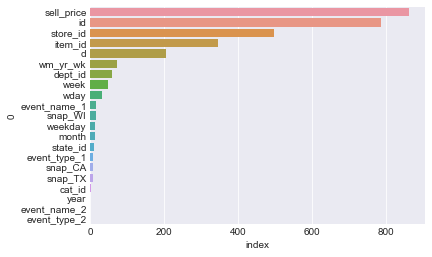

In [55]:
sns.barplot(data=fea_im , x='index' , y=0)

### ลองเลือก features ที่สำคัญดู

In [57]:
data_train.columns

Index(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'd',
       'sale', 'wm_yr_wk', 'weekday', 'wday', 'month', 'year', 'event_name_1',
       'event_type_1', 'event_name_2', 'event_type_2', 'snap_CA', 'snap_TX',
       'snap_WI', 'sell_price', 'week'],
      dtype='object')

In [58]:
features = ['sell_price','id','store_id','item_id','d','wm_yr_wk','dept_id','week','wday']

In [60]:
model = lightgbm.LGBMRegressor()

In [61]:
model.fit(data_train[features] , data_train['sale'])

LGBMRegressor()

In [62]:
predict_2 = model.predict(data_test[features])

### ประเมินผลโมเดลอีกรอบ

In [63]:
print(f"R-square = {r2_score(data_test['sale'] , predict_2)}")
print(f"MAE = {mean_absolute_error(data_test['sale'] , predict_2)}")
print(f"MSE = {mean_squared_error(data_test['sale'] , predict_2)}")
print(f"RMSE = {np.sqrt(mean_squared_error(data_test['sale'] , predict_2))}")

R-square = 0.34842320511133196
MAE = 1.4073952595154164
MSE = 8.412709758261313
RMSE = 2.900467162072571
